# Cell Perturbation Prediction using VAE

## Task Background

This notebook implements a Variational Autoencoder (VAE) for predicting cellular responses to perturbations in single-cell RNA sequencing data. The main objective is to learn a latent representation of cell states and predict how cells transition from control to perturbed conditions.

**Key Concepts:**
- **Control cells**: Cells in their baseline, unperturbed state
- **Perturbed cells**: Cells that have undergone some treatment or perturbation
- **Latent space shift**: The VAE learns to capture the biological effect of perturbation as a shift in latent space

**Workflow:**
1. Train a VAE to reconstruct gene expression profiles
2. Compute the latent space shift from control to perturbed states using reference data
3. Apply this learned shift to predict perturbed states of new control cells
4. Evaluate predictions using various metrics and visualizations

**Applications:**
- Drug response prediction
- Understanding cellular mechanisms of perturbation
- In-silico experimentation to reduce costly wet-lab experiments

In [1]:
!nvidia-smi


Fri Nov 14 00:44:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchvision torchaudio \
    scanpy \
    pandas numpy scipy \
    matplotlib seaborn \
    tqdm \
    scikit-learn \
    umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 8.5 MB/s eta 0:00:00


## 1. Import Libraries and Setup

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import umap

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


## 2. Set Random Seed for Reproducibility

In [4]:
def set_seed(seed=42):
    """Set random seed for reproducibility across different libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42")

Random seed set to 42


## 3. Data Loading Functions

In [5]:
def load_h5ad_onlyX(file_path):
    """
    Load gene expression matrix from h5ad file.

    Args:
        file_path: Path to the h5ad file
    Returns:
        X: Gene expression matrix as numpy array (cells x genes)
    """
    adata = sc.read_h5ad(file_path)
    if hasattr(adata.X, "toarray"):
        X = adata.X.toarray()  # Convert sparse to dense if needed
    else:
        X = adata.X
    X = np.array(X).astype(np.float32)
    return X

def load_h5ad_control_perturb(file_path):
    """
    Load control and perturbed cells separately from h5ad file.

    Args:
        file_path: Path to the h5ad file
    Returns:
        ctrl_x: Control cells expression matrix
        ptrb_x: Perturbed cells expression matrix
    """
    adata = sc.read_h5ad(file_path)
    ctrl_x = adata[adata.obs['condition'] == 'control', :].X
    ptrb_x = adata[adata.obs['condition'] == 'perturb', :].X

    # Convert to dense array if sparse
    if hasattr(ctrl_x, "toarray"):
        ctrl_x = ctrl_x.toarray()
    if hasattr(ptrb_x, "toarray"):
        ptrb_x = ptrb_x.toarray()

    ctrl_x = np.array(ctrl_x).astype(np.float32)
    ptrb_x = np.array(ptrb_x).astype(np.float32)
    return ctrl_x, ptrb_x

def load_h5ad(file_path):
    """
    Load complete AnnData object from h5ad file.

    Args:
        file_path: Path to the h5ad file
    Returns:
        adata: AnnData object containing expression and metadata
    """
    adata = sc.read_h5ad(file_path)
    return adata

print("Data loading functions defined")

Data loading functions defined


## 4. VAE Model Architecture

In [6]:
class VAE(nn.Module):
    """
    Variational Autoencoder for gene expression data.

    The VAE consists of:
    - Encoder: Maps input to latent space (mean and log-variance)
    - Decoder: Reconstructs input from latent representation
    - Reparameterization: Enables gradient flow through stochastic sampling
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """
        Args:
            input_dim: Number of input features (genes)
            hidden_dim: Size of hidden layer
            latent_dim: Dimension of latent space
        """
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)  # Mean of latent distribution
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance of latent distribution

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        # Activation functions
        self.acfunc_enc = nn.ReLU()
        self.acfunc_dec = nn.ReLU()

    def encode(self, x):
        """
        Encode input to latent distribution parameters.

        Args:
            x: Input tensor (batch_size, input_dim)
        Returns:
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        """
        h = self.acfunc_enc(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from latent distribution.
        z = mu + sigma * epsilon, where epsilon ~ N(0,1)

        Args:
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        Returns:
            z: Sampled latent vector
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Sample from standard normal
        return mu + eps * std

    def decode(self, z):
        """
        Decode latent representation to reconstruct input.

        Args:
            z: Latent representation
        Returns:
            out: Reconstructed output
        """
        h = self.acfunc_dec(self.fc3(z))
        out = self.fc4(h)
        return out

    def forward(self, x):
        """
        Forward pass through VAE.

        Args:
            x: Input tensor
        Returns:
            out: Reconstructed output
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

    def compute_ref_latent_shift(self, x_ref_adata):
        """
        Compute latent space shift from control to perturbed states using reference data.
        This shift captures the biological effect of perturbation.

        Args:
            x_ref_adata: Reference AnnData object containing both control and perturbed cells
        Returns:
            latent_bio_context: Vector representing the perturbation effect in latent space
        """
        condition_key = 'condition'

        # Extract control and perturbed cells from reference
        ctrl_x_ref = x_ref_adata[x_ref_adata.obs[condition_key] == 'control', :].X
        ptrb_x_ref = x_ref_adata[x_ref_adata.obs[condition_key] == 'perturb', :].X

        # Convert to dense if sparse
        if hasattr(ctrl_x_ref, "toarray"):
            ctrl_x_ref = ctrl_x_ref.toarray()
        if hasattr(ptrb_x_ref, "toarray"):
            ptrb_x_ref = ptrb_x_ref.toarray()

        # Convert to tensors
        device = next(self.parameters()).device
        ctrl_x_ref = torch.tensor(np.array(ctrl_x_ref), dtype=torch.float32).to(device)
        ptrb_x_ref = torch.tensor(np.array(ptrb_x_ref), dtype=torch.float32).to(device)

        with torch.no_grad():
            # Encode control cells to latent space
            mu_ctrl_x_ref, logvar_ctrl_x_ref = self.encode(ctrl_x_ref)
            z_ctrl_x_ref = self.reparameterize(mu_ctrl_x_ref, logvar_ctrl_x_ref)

            # Encode perturbed cells to latent space
            mu_ptrb_x_ref, logvar_ptrb_x_ref = self.encode(ptrb_x_ref)
            z_ptrb_x_ref = self.reparameterize(mu_ptrb_x_ref, logvar_ptrb_x_ref)

            # Compute average latent representations
            latent_ctrl_ref = torch.mean(z_ctrl_x_ref, dim=0)
            latent_ptrb_ref = torch.mean(z_ptrb_x_ref, dim=0)

            # Compute shift: perturbation effect in latent space
            latent_bio_context = latent_ptrb_ref - latent_ctrl_ref

        return latent_bio_context

    def predict_with_precomputed_shift(self, x, latent_bio_context):
        """
        Predict perturbed state by applying precomputed latent shift to control cells.

        Args:
            x: Control cell expression (batch_size, input_dim)
            latent_bio_context: Precomputed perturbation shift vector
        Returns:
            predicted_exp: Predicted perturbed cell expression
        """
        mu, logvar = self.encode(x)
        latent_ctrl_qry = self.reparameterize(mu, logvar)

        # Apply perturbation shift in latent space
        latent_ptrb_qry = latent_ctrl_qry + latent_bio_context

        # Decode to get predicted expression
        predicted_exp = self.decode(latent_ptrb_qry)

        return predicted_exp

print("VAE model defined")

VAE model defined


## 5. Loss Function

In [ ]:
def vae_loss(recon_x, x, mu, logvar, kl_weight=0.1):
    """
    Compute VAE loss = Reconstruction Loss + KL Divergence.

    The reconstruction loss measures how well the VAE reconstructs the input,
    while KL divergence regularizes the latent space to follow a standard normal distribution.

    Args:
        recon_x: Reconstructed input
        x: Original input
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        kl_weight: Weight for KL divergence term (default: 0.1)
    Returns:
        total_loss: Combined loss
        mse_loss: Reconstruction loss (MSE)
        kld_loss: KL divergence loss
    """
    # Reconstruction loss: Mean Squared Error
    mse_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence: measures distance between learned and prior distribution
    # KL(N(mu, sigma) || N(0, 1)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combined loss
    total_loss = mse_loss + kl_weight * kld_loss

    return total_loss, mse_loss, kld_loss

print("Loss function defined")

Loss function defined


## 6. Evaluation Metrics

In [ ]:
def evaluate_prediction_samplewise(pred, true):
    """
    Evaluate prediction quality using multiple metrics computed per sample.

    Args:
        pred: Predicted expression matrix (n_cells, n_genes)
        true: True expression matrix (n_cells, n_genes)
    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    # Mean Squared Error per sample
    mse_per_sample = np.mean((pred - true) ** 2, axis=1)
    mse_mean = np.mean(mse_per_sample)
    mse_std = np.std(mse_per_sample)

    # Pearson correlation per sample (gene-gene correlation)
    pearson_per_sample = []
    for i in range(pred.shape[0]):
        if np.std(pred[i]) > 0 and np.std(true[i]) > 0:  # Avoid division by zero
            corr, _ = pearsonr(pred[i], true[i])
            pearson_per_sample.append(corr)

    pearson_mean = np.mean(pearson_per_sample) if pearson_per_sample else 0
    pearson_std = np.std(pearson_per_sample) if pearson_per_sample else 0

    # Mean Absolute Error
    mae = np.mean(np.abs(pred - true))

    # R-squared (coefficient of determination)
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    metrics = {
        'MSE_mean': mse_mean,
        'MSE_std': mse_std,
        'Pearson_mean': pearson_mean,
        'Pearson_std': pearson_std,
        'MAE': mae,
        'R2': r2
    }

    return metrics

def evaluate_val_prediction(model, val_data_path, X_ref, device, batch_size=64):
    """
    Evaluate model on validation set by predicting perturbed states from control cells.

    Args:
        model: Trained VAE model
        val_data_path: Path to validation h5ad file
        X_ref: Reference AnnData for computing latent shift
        device: torch device (cpu/cuda)
        batch_size: Batch size for evaluation
    Returns:
        val_mse: Mean squared error on validation set
        val_metrics: Dictionary of evaluation metrics
    """
    model.eval()

    # Precompute latent shift once
    latent_bio_context = model.compute_ref_latent_shift(X_ref)

    # Load validation data
    ctrl_x, ptrb_x = load_h5ad_control_perturb(val_data_path)
    val_dataset = TensorDataset(torch.tensor(ctrl_x), torch.tensor(ptrb_x))
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    all_pred = []
    all_true = []

    with torch.no_grad():
        for ctrl_batch, ptrb_batch in val_dataloader:
            ctrl_batch = ctrl_batch.to(device)
            ptrb_batch = ptrb_batch.to(device)

            # Predict perturbed state using precomputed shift
            predicted_ptrb = model.predict_with_precomputed_shift(ctrl_batch, latent_bio_context)

            all_pred.append(predicted_ptrb.cpu().numpy())
            all_true.append(ptrb_batch.cpu().numpy())

    # Concatenate all batches
    all_pred = np.concatenate(all_pred, axis=0)
    all_true = np.concatenate(all_true, axis=0)

    # Compute metrics
    val_mse = np.mean((all_pred - all_true) ** 2)
    val_metrics = evaluate_prediction_samplewise(all_pred, all_true)

    return val_mse, val_metrics

print("Evaluation functions defined")

Evaluation functions defined


## 7. Configuration and Hyperparameters

In [ ]:
# Configuration
config = {
    # Data paths - UPDATE THESE TO YOUR DATA PATHS
    'train_data_path': './split_train.h5ad',
    'val_data_path': './split_val.h5ad',
    'test_data_path': './split_test.h5ad',

    # Model hyperparameters
    'hidden_dim': 300,      # Size of hidden layer
    'latent_dim': 100,      # Dimension of latent space

    # Training hyperparameters
    'epochs': 5,           # Number of training epochs
    'batch_size': 64,       # Batch size for training
    'lr': 1e-3,            # Learning rate
    'weight_decay': 1e-5,  # L2 regularization
    'kl_weight': 0.1,      # Weight for KL divergence in loss

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  train_data_path: ./split_train.h5ad
  val_data_path: ./split_val.h5ad
  test_data_path: ./split_test.h5ad
  hidden_dim: 300
  latent_dim: 100
  epochs: 5
  batch_size: 64
  lr: 0.001
  weight_decay: 1e-05
  kl_weight: 0.1
  device: cuda


## 8. Load and Prepare Data

In [ ]:
# Load training data
print("Loading training data...")
X_train = load_h5ad_onlyX(config['train_data_path'])
print(f"Training data shape: {X_train.shape}")
print(f"Number of cells: {X_train.shape[0]}")
print(f"Number of genes: {X_train.shape[1]}")

# Load reference data (for computing latent shift)
print("\nLoading reference data...")
X_ref = load_h5ad(config['train_data_path'])
print(f"Reference data loaded with {X_ref.shape[0]} cells")

# Create data loader
train_dataset = TensorDataset(torch.tensor(X_train))
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True
)
print(f"\nCreated data loader with batch size {config['batch_size']}")
print(f"Number of batches per epoch: {len(train_dataloader)}")

Loading training data...
Training data shape: (94284, 978)
Number of cells: 94284
Number of genes: 978

Loading reference data...
Reference data loaded with 94284 cells

Created data loader with batch size 64
Number of batches per epoch: 1474


## 9. Initialize Model and Optimizer

In [ ]:
# Get input dimension from data
input_dim = X_train.shape[1]

# Initialize model
model = VAE(
    input_dim=input_dim,
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim']
).to(config['device'])

# Initialize optimizer (Adam)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay']
)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Device: {config['device']}")
print("\nModel architecture:")
print(model)

Model initialized with 678578 parameters
Device: cuda

Model architecture:
VAE(
  (fc1): Linear(in_features=978, out_features=300, bias=True)
  (fc2_mu): Linear(in_features=300, out_features=100, bias=True)
  (fc2_logvar): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=978, bias=True)
  (acfunc_enc): ReLU()
  (acfunc_dec): ReLU()
)


## 10. Training Loop

In [ ]:
# Training history storage
history = {
    'train_loss': [],
    'train_mse': [],
    'train_kld': [],
    'val_mse': [],
    'val_pearson': []
}

best_val_mse = float('inf')
best_epoch = 0

print("Starting training...\n")
print("=" * 80)

for epoch in range(config['epochs']):
    model.train()

    # Training metrics for this epoch
    epoch_loss = 0
    epoch_mse = 0
    epoch_kld = 0
    total_samples = 0

    # Training loop with progress bar
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")

    for batch in pbar:
        x = batch[0].to(config['device'])

        # Forward pass
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)

        # Compute loss
        loss, mse, kld = vae_loss(recon_x, x, mu, logvar, config['kl_weight'])

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        batch_size = x.size(0)
        total_samples += batch_size
        epoch_loss += loss.item()
        epoch_mse += mse.item()
        epoch_kld += kld.item()

        # Update progress bar
        pbar.set_postfix({
            'Loss': f"{epoch_loss/total_samples:.4f}",
            'MSE': f"{epoch_mse/total_samples:.4f}",
            'KLD': f"{epoch_kld/total_samples:.4f}"
        })

    # Compute average training metrics
    avg_train_loss = epoch_loss / total_samples
    avg_train_mse = epoch_mse / total_samples
    avg_train_kld = epoch_kld / total_samples

    # Evaluate on validation set
    val_mse, val_metrics = evaluate_val_prediction(
        model, config['val_data_path'], X_ref, config['device'], config['batch_size']
    )

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_mse'].append(avg_train_mse)
    history['train_kld'].append(avg_train_kld)
    history['val_mse'].append(val_mse)
    history['val_pearson'].append(val_metrics['Pearson_mean'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{config['epochs']} Summary:")
    print(f"  Train Loss: {avg_train_loss:.6f}")
    print(f"  Train MSE: {avg_train_mse:.6f}")
    print(f"  Train KLD: {avg_train_kld:.6f}")
    print(f"  Val MSE: {val_mse:.6f}")
    print(f"  Val Pearson: {val_metrics['Pearson_mean']:.6f}")

    # Save best model
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_epoch = epoch
        torch.save(model.state_dict(), "best_vae_model.pth")
        print(f"  *** New best model saved! ***")

    print("=" * 80)

print(f"\nTraining completed!")
print(f"Best validation MSE: {best_val_mse:.6f} at epoch {best_epoch+1}")

Starting training...



Epoch 1/5: 100%|██████████| 1474/1474 [00:05<00:00, 285.76it/s, Loss=523.9855, MSE=497.4981, KLD=264.8744]



Epoch 1/5 Summary:
  Train Loss: 523.985535
  Train MSE: 497.498094
  Train KLD: 264.874406
  Val MSE: 0.599596
  Val Pearson: 0.938645
  *** New best model saved! ***


Epoch 2/5: 100%|██████████| 1474/1474 [00:05<00:00, 265.75it/s, Loss=449.7291, MSE=424.3378, KLD=253.9129]



Epoch 2/5 Summary:
  Train Loss: 449.729109
  Train MSE: 424.337823
  Train KLD: 253.912865
  Val MSE: 0.537564
  Val Pearson: 0.945560
  *** New best model saved! ***


Epoch 3/5: 100%|██████████| 1474/1474 [00:05<00:00, 277.03it/s, Loss=413.3994, MSE=388.8759, KLD=245.2351]



Epoch 3/5 Summary:
  Train Loss: 413.399421
  Train MSE: 388.875907
  Train KLD: 245.235140
  Val MSE: 0.564268
  Val Pearson: 0.948620


Epoch 4/5: 100%|██████████| 1474/1474 [00:05<00:00, 276.38it/s, Loss=391.2192, MSE=367.6904, KLD=235.2874]



Epoch 4/5 Summary:
  Train Loss: 391.219170
  Train MSE: 367.690427
  Train KLD: 235.287432
  Val MSE: 0.492325
  Val Pearson: 0.950609
  *** New best model saved! ***


Epoch 5/5: 100%|██████████| 1474/1474 [00:04<00:00, 304.66it/s, Loss=377.7009, MSE=355.1016, KLD=225.9933]



Epoch 5/5 Summary:
  Train Loss: 377.700939
  Train MSE: 355.101611
  Train KLD: 225.993288
  Val MSE: 0.479531
  Val Pearson: 0.951917
  *** New best model saved! ***

Training completed!
Best validation MSE: 0.479531 at epoch 5


## 11. Plot Training History

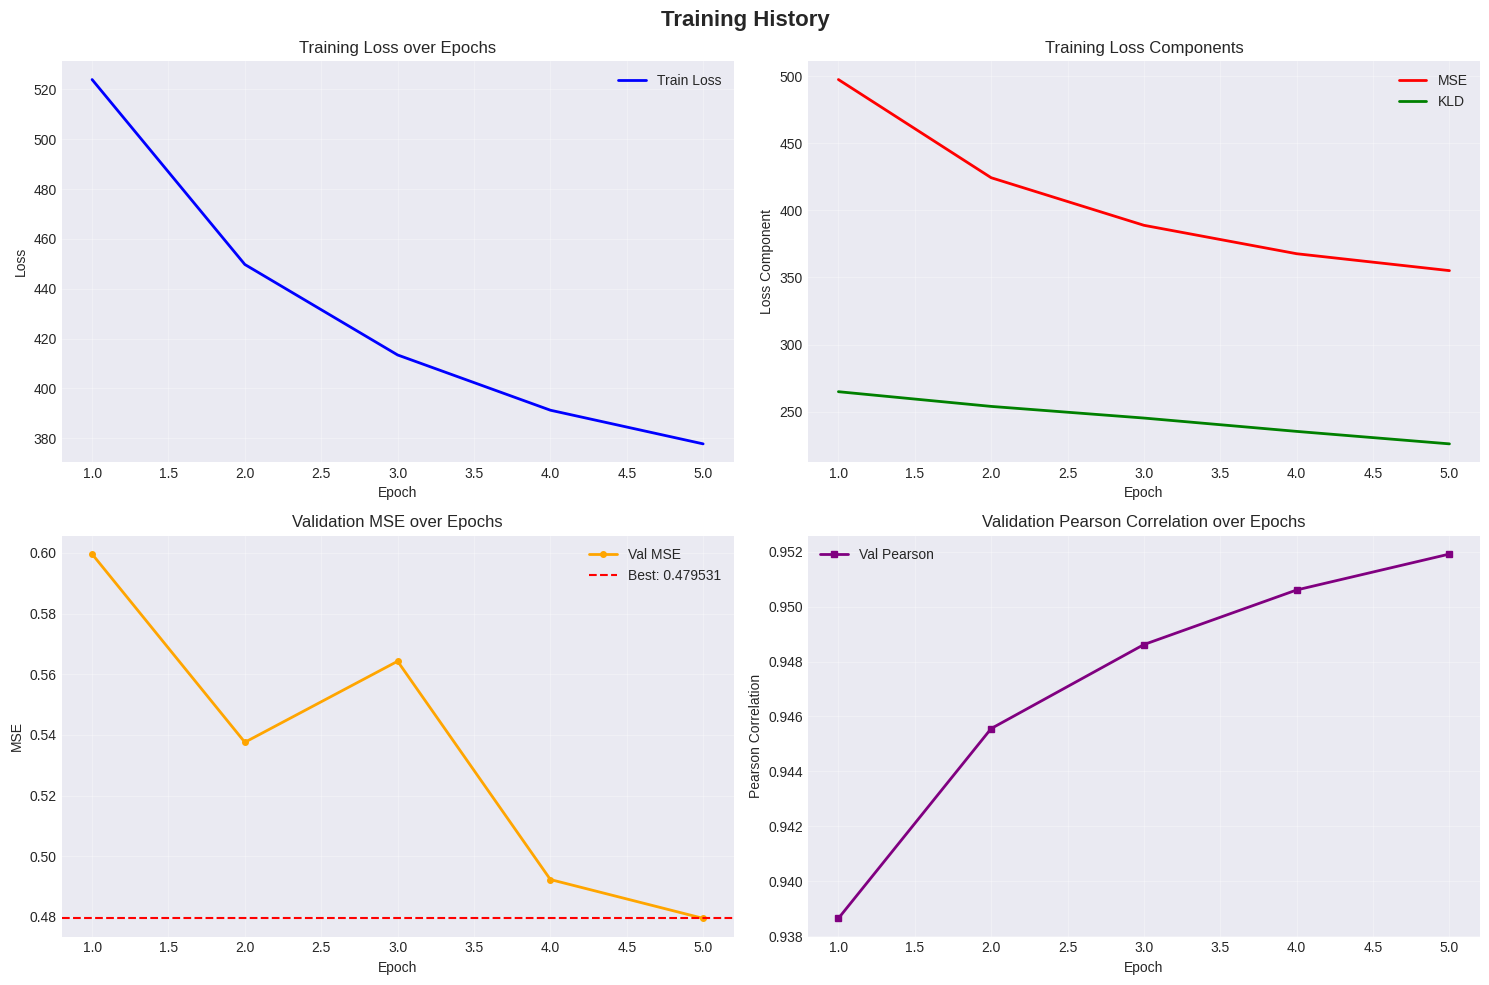

Training history plots saved as 'training_history.png'


In [ ]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

epochs_range = range(1, config['epochs'] + 1)

# Plot 1: Training Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training MSE and KLD
axes[0, 1].plot(epochs_range, history['train_mse'], 'r-', linewidth=2, label='MSE')
axes[0, 1].plot(epochs_range, history['train_kld'], 'g-', linewidth=2, label='KLD')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss Component')
axes[0, 1].set_title('Training Loss Components')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Validation MSE
axes[1, 0].plot(epochs_range, history['val_mse'], 'orange', linewidth=2, marker='o',
                markersize=4, label='Val MSE')
axes[1, 0].axhline(y=best_val_mse, color='r', linestyle='--', label=f'Best: {best_val_mse:.6f}')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Validation MSE over Epochs')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Validation Pearson Correlation
axes[1, 1].plot(epochs_range, history['val_pearson'], 'purple', linewidth=2, marker='s',
                markersize=4, label='Val Pearson')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Pearson Correlation')
axes[1, 1].set_title('Validation Pearson Correlation over Epochs')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved as 'training_history.png'")

## 12. Load Best Model and Evaluate

In [ ]:
# Load best model
model.load_state_dict(torch.load("best_vae_model.pth"))
model.eval()
print("Best model loaded successfully")

# Evaluate on test set
print("\nEvaluating on test set...")
print("=" * 80)

# Load test data
ctrl_x_test, ptrb_x_test = load_h5ad_control_perturb(config['test_data_path'])
print(f"Test set: {ctrl_x_test.shape[0]} control cells, {ptrb_x_test.shape[0]} perturbed cells")

# Precompute latent shift
latent_bio_context = model.compute_ref_latent_shift(X_ref)

# Create test dataloader
test_dataset = TensorDataset(torch.tensor(ctrl_x_test), torch.tensor(ptrb_x_test))
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Predict on test set
all_pred_test = []
all_true_test = []
all_ctrl_test = []

with torch.no_grad():
    for ctrl_batch, ptrb_batch in tqdm(test_dataloader, desc="Predicting"):
        ctrl_batch = ctrl_batch.to(config['device'])
        ptrb_batch = ptrb_batch.to(config['device'])

        # Predict perturbed state
        predicted_ptrb = model.predict_with_precomputed_shift(ctrl_batch, latent_bio_context)

        all_pred_test.append(predicted_ptrb.cpu().numpy())
        all_true_test.append(ptrb_batch.cpu().numpy())
        all_ctrl_test.append(ctrl_batch.cpu().numpy())

# Concatenate results
all_pred_test = np.concatenate(all_pred_test, axis=0)
all_true_test = np.concatenate(all_true_test, axis=0)
all_ctrl_test = np.concatenate(all_ctrl_test, axis=0)

print(f"\nPrediction shape: {all_pred_test.shape}")

# Compute metrics
test_mse = np.mean((all_pred_test - all_true_test) ** 2)
test_metrics = evaluate_prediction_samplewise(all_pred_test, all_true_test)

print("\nTest Set Prediction Metrics:")
print("=" * 80)
print(f"MSE: {test_mse:.6f}")
for key, value in test_metrics.items():
    print(f"{key}: {value:.6f}")
print("=" * 80)

Best model loaded successfully

Evaluating on test set...
Test set: 15713 control cells, 15713 perturbed cells


Predicting: 100%|██████████| 246/246 [00:00<00:00, 603.44it/s]



Prediction shape: (15713, 978)

Test Set Prediction Metrics:
MSE: 0.501143
MSE_mean: 0.501143
MSE_std: 0.424807
Pearson_mean: 0.950075
Pearson_std: 0.038388
MAE: 0.486191
R2: 0.898884


## 13. Extract Latent Embeddings for Visualization

In [ ]:
def extract_latent_embeddings(model, data, device, batch_size=64):
    """
    Extract latent embeddings from the VAE encoder.

    Args:
        model: Trained VAE model
        data: Input data array
        device: torch device
        batch_size: Batch size for processing
    Returns:
        latent_embeddings: Latent representations (n_samples, latent_dim)
    """
    model.eval()
    dataset = TensorDataset(torch.tensor(data))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    latent_list = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            latent_list.append(z.cpu().numpy())

    latent_embeddings = np.concatenate(latent_list, axis=0)
    return latent_embeddings

# Load test data with metadata for cell type information
print("Loading test data with metadata...")
test_adata = load_h5ad(config['test_data_path'])

# Extract control and perturbed cells separately
ctrl_adata = test_adata[test_adata.obs['condition'] == 'control']
ptrb_adata = test_adata[test_adata.obs['condition'] == 'perturb']

print(f"Control cells: {ctrl_adata.shape[0]}")
print(f"Perturbed cells: {ptrb_adata.shape[0]}")

# Extract cell type labels
if 'cell_type' in ctrl_adata.obs.columns:
    cell_types_ctrl = ctrl_adata.obs['cell_type'].values
    cell_types_ptrb = ptrb_adata.obs['cell_type'].values
    print(f"\nUnique cell types: {np.unique(np.concatenate([cell_types_ctrl, cell_types_ptrb]))}")
else:
    print("Warning: 'cell_type' column not found in metadata. Using default labels.")
    cell_types_ctrl = np.array(['Control'] * ctrl_adata.shape[0])
    cell_types_ptrb = np.array(['Perturbed'] * ptrb_adata.shape[0])

# Extract latent embeddings
print("\nExtracting latent embeddings...")
latent_ctrl = extract_latent_embeddings(model, all_ctrl_test, config['device'])
latent_true_ptrb = extract_latent_embeddings(model, all_true_test, config['device'])
latent_pred_ptrb = extract_latent_embeddings(model, all_pred_test, config['device'])

print(f"Latent embeddings shape: {latent_ctrl.shape}")
print("Latent embeddings extracted successfully")

Loading test data with metadata...
Control cells: 15713
Perturbed cells: 15713

Unique cell types: ['1HAE' '22RV1' '5637' 'A204' 'A375' 'A549' 'AGS' 'AN3CA' 'ASC' 'BC3C'
 'BEN' 'BICR6' 'BJAB' 'BT20' 'BT474' 'CAL29' 'CD34' 'CJM' 'COV434' 'CW2'
 'DV90' 'ES2' 'G401' 'GI1' 'GP2D' 'H1975' 'HA1E' 'HBL1' 'HCC1588' 'HCC515'
 'HCC95' 'HCT116' 'HEC108' 'HEC151' 'HEC1A' 'HEC251' 'HEC265' 'HEK293'
 'HEK293T' 'HELA' 'HEPG2' 'HFL1' 'HL60' 'HME1' 'HMELZ' 'HPTEC' 'HS578T'
 'HT29' 'HUES3' 'HUH7' 'HUVEC' 'IGR37' 'IM95' 'IMR90' 'J82' 'JHH5' 'JHH7'
 'JURKAT' 'K562' 'KMS34' 'LNCAP' 'MCF10A' 'MCF7' 'MDAMB231' 'MDAMB468'
 'MELHO' 'MFE319' 'MINO' 'MKN45' 'MNEU' 'NALM6' 'NCIH1437' 'NCIH1563'
 'NCIH1573' 'NCIH1781' 'NCIH1975' 'NCIH2073' 'NCIH2110' 'NCIH2172'
 'NCIH508' 'NCIH596' 'NCIH838' 'NCIH841' 'NEU' 'NKDBA' 'NL20' 'NOMO1'
 'NPC' 'OAW28' 'OC314' 'OC316' 'OCILY10' 'OCILY19' 'OCILY3' 'OVCAR8'
 'OVK18' 'OVTOKO' 'P1A82' 'PC3' 'PHH' 'RCC10RGB' 'SH4' 'SHSY5Y' 'SKB'
 'SKBR3' 'SKES1' 'SKL' 'SKMEL3' 'SKMEL5' 'SKNSH'

## 14. UMAP Visualization: Latent Embeddings by Cell Type

Computing UMAP for latent embeddings...


/home/exouser/miniconda3/envs/info/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_7441/1423797653.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


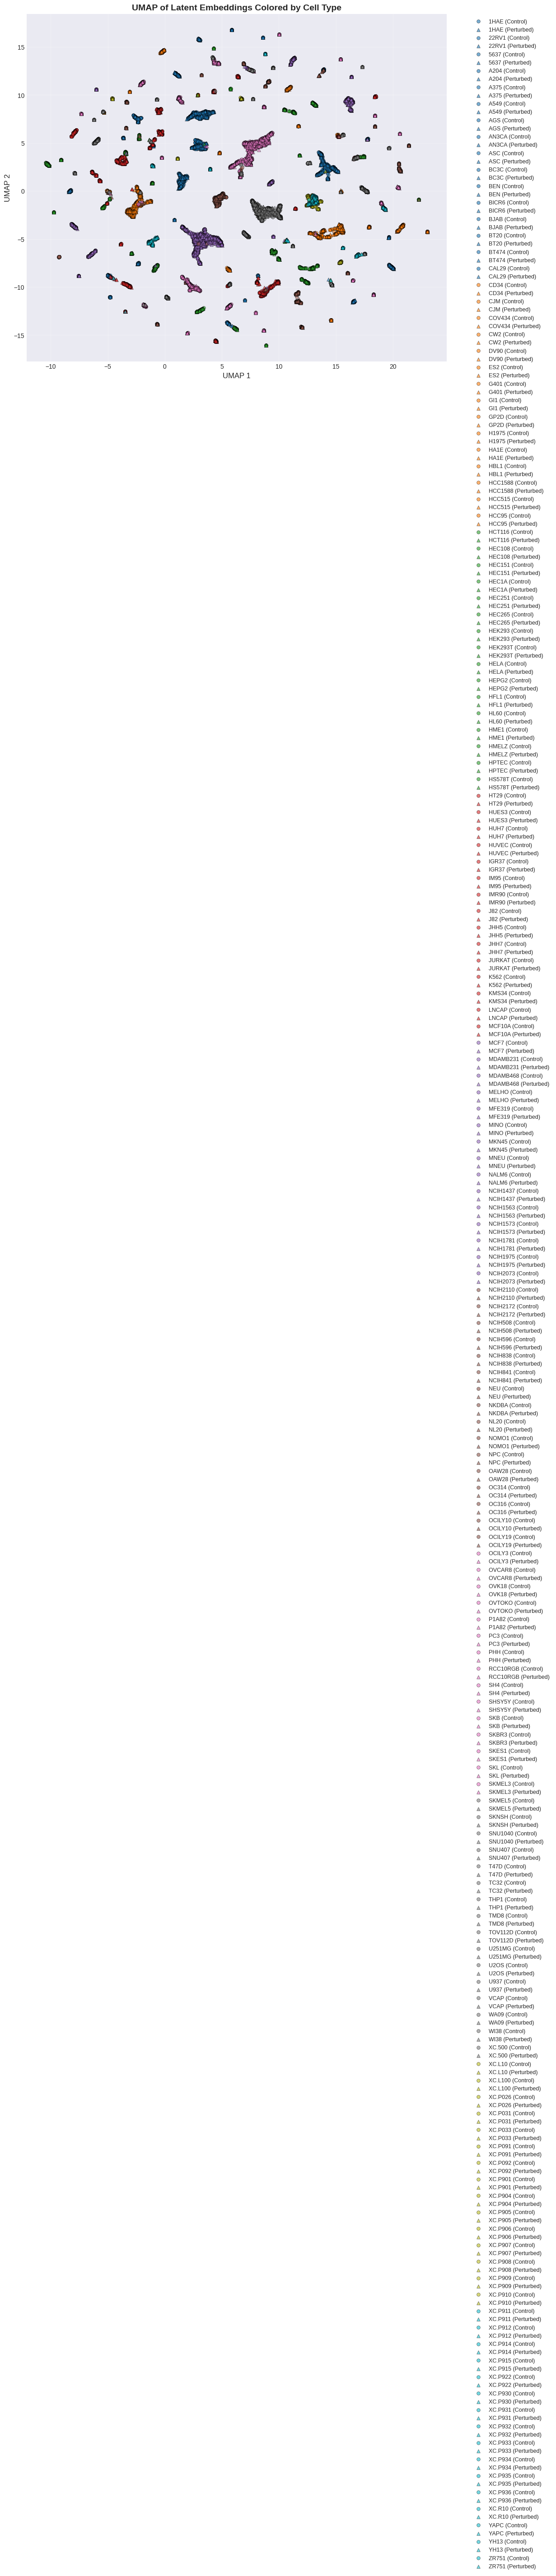

UMAP visualization saved as 'umap_latent_celltype.png'


In [ ]:
# Compute UMAP for latent embeddings
print("Computing UMAP for latent embeddings...")

# Combine all latent embeddings for UMAP fitting
all_latent = np.vstack([latent_ctrl, latent_true_ptrb])

# Fit UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(all_latent)

# Split back into control and perturbed
n_ctrl = latent_ctrl.shape[0]
umap_ctrl = umap_embedding[:n_ctrl]
umap_true_ptrb = umap_embedding[n_ctrl:]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot control cells
unique_types = np.unique(cell_types_ctrl)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))

for i, cell_type in enumerate(unique_types):
    # Control cells of this type
    mask_ctrl = cell_types_ctrl == cell_type
    ax.scatter(umap_ctrl[mask_ctrl, 0], umap_ctrl[mask_ctrl, 1],
              c=[colors[i]], label=f"{cell_type} (Control)",
              alpha=0.6, s=30, edgecolors='k', linewidths=0.5)

    # Perturbed cells of this type
    mask_ptrb = cell_types_ptrb == cell_type
    ax.scatter(umap_true_ptrb[mask_ptrb, 0], umap_true_ptrb[mask_ptrb, 1],
              c=[colors[i]], label=f"{cell_type} (Perturbed)",
              alpha=0.6, s=30, marker='^', edgecolors='k', linewidths=0.5)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('UMAP of Latent Embeddings Colored by Cell Type', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('umap_latent_celltype.png', dpi=300, bbox_inches='tight')
plt.show()

print("UMAP visualization saved as 'umap_latent_celltype.png'")

## 15. UMAP Visualization: Predicted vs True (Latent Space)

Computing UMAP for predicted vs true latent embeddings...


/home/exouser/miniconda3/envs/info/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_7441/2839603065.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


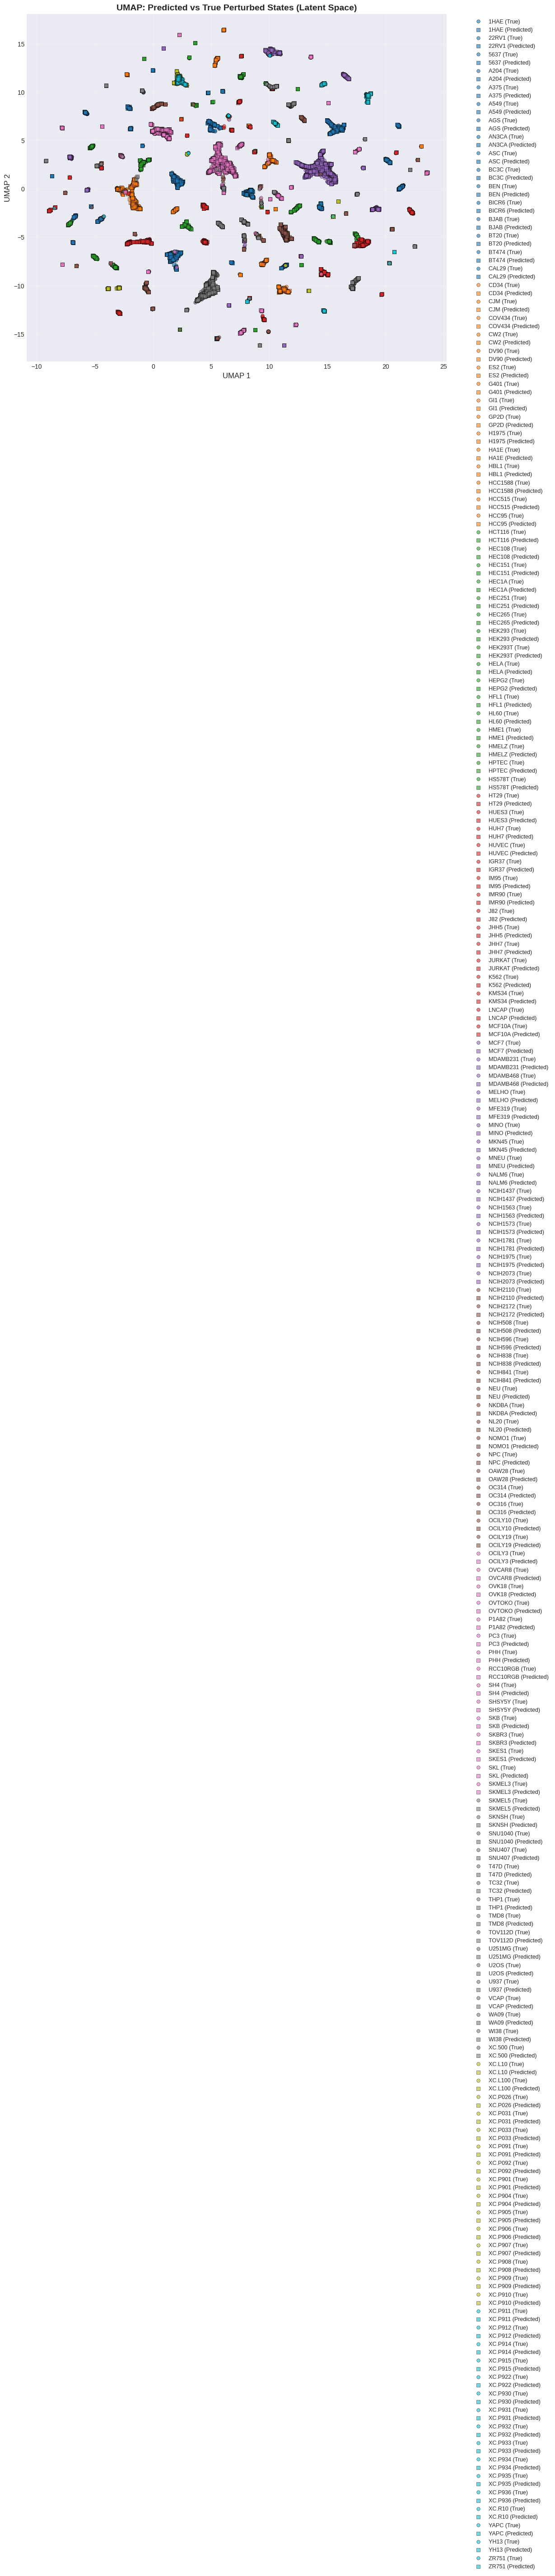

UMAP visualization saved as 'umap_predicted_vs_true_latent.png'


In [ ]:
# Compute UMAP for predicted embeddings
print("Computing UMAP for predicted vs true latent embeddings...")

# Combine true and predicted perturbed latent embeddings
combined_latent = np.vstack([latent_true_ptrb, latent_pred_ptrb])

# Fit UMAP
umap_reducer_pred = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_combined = umap_reducer_pred.fit_transform(combined_latent)

# Split back
n_true = latent_true_ptrb.shape[0]
umap_true = umap_combined[:n_true]
umap_pred = umap_combined[n_true:]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot by cell type
for i, cell_type in enumerate(unique_types):
    mask = cell_types_ptrb == cell_type

    # True perturbed
    ax.scatter(umap_true[mask, 0], umap_true[mask, 1],
              c=[colors[i]], label=f"{cell_type} (True)",
              alpha=0.6, s=30, marker='o', edgecolors='k', linewidths=0.5)

    # Predicted perturbed
    ax.scatter(umap_pred[mask, 0], umap_pred[mask, 1],
              c=[colors[i]], label=f"{cell_type} (Predicted)",
              alpha=0.6, s=30, marker='s', edgecolors='k', linewidths=0.5)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('UMAP: Predicted vs True Perturbed States (Latent Space)',
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('umap_predicted_vs_true_latent.png', dpi=300, bbox_inches='tight')
plt.show()

print("UMAP visualization saved as 'umap_predicted_vs_true_latent.png'")

## 16. UMAP Visualization: Predicted vs True Expression Space

Computing UMAP for expression space comparison...


/home/exouser/miniconda3/envs/info/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/exouser/miniconda3/envs/info/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_7441/356546365.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


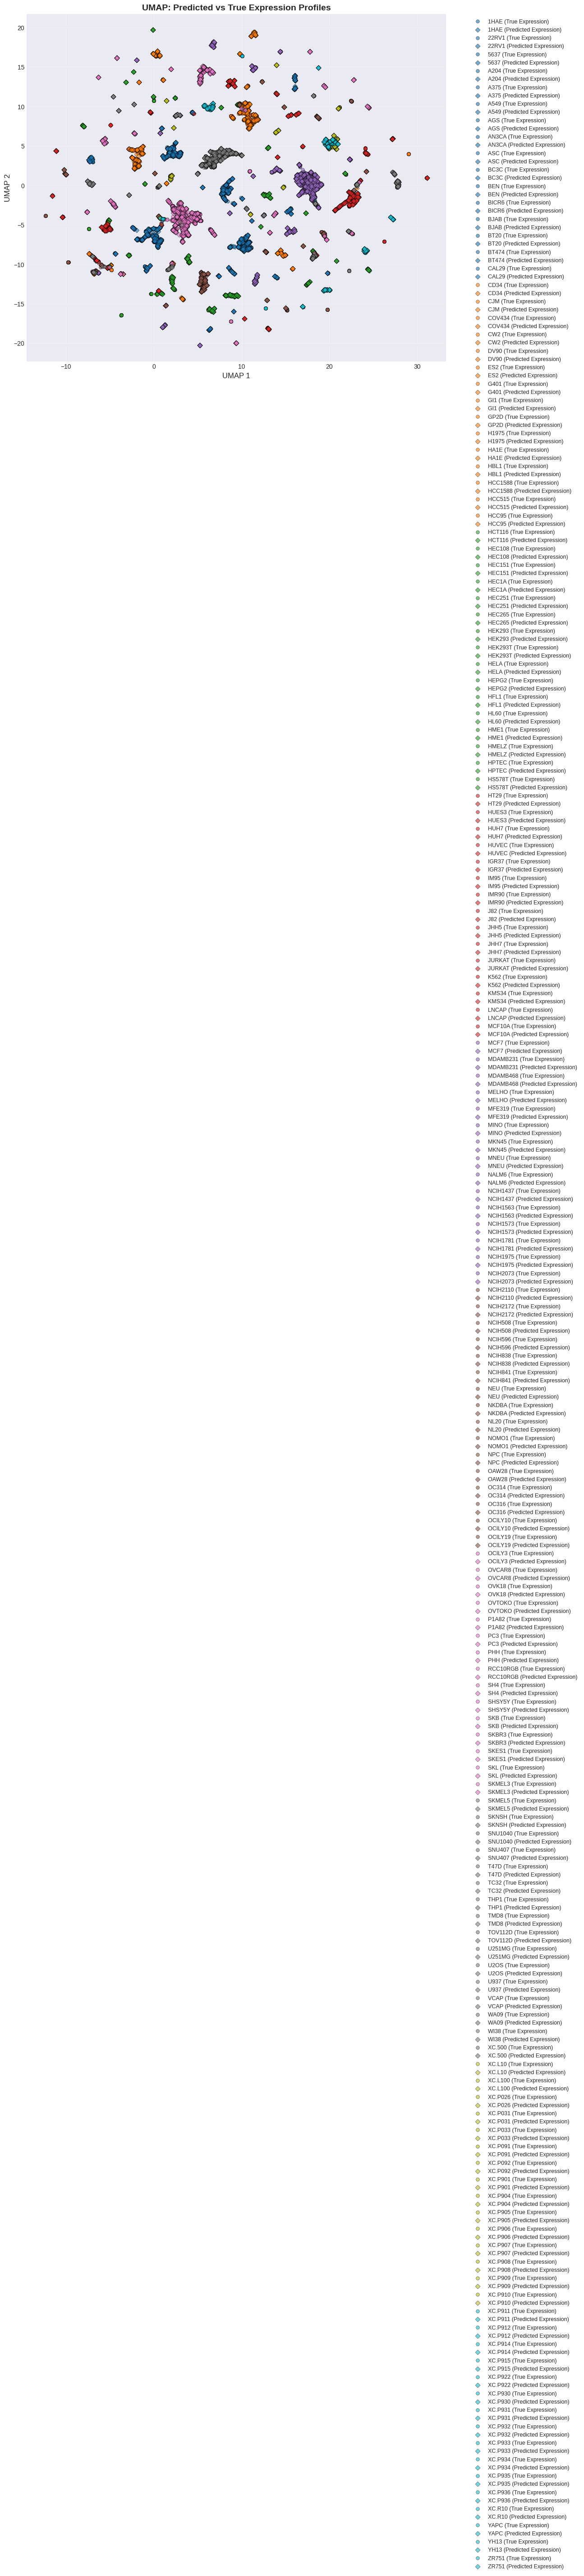

UMAP visualization saved as 'umap_predicted_vs_true_expression.png'


In [ ]:
# Compute UMAP in expression space (gene expression level)
print("Computing UMAP for expression space comparison...")

# Combine true and predicted expression
combined_exp = np.vstack([all_true_test, all_pred_test])

# Fit UMAP on expression data
umap_reducer_exp = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_exp_combined = umap_reducer_exp.fit_transform(combined_exp)

# Split back
n_true_exp = all_true_test.shape[0]
umap_true_exp = umap_exp_combined[:n_true_exp]
umap_pred_exp = umap_exp_combined[n_true_exp:]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot by cell type
for i, cell_type in enumerate(unique_types):
    mask = cell_types_ptrb == cell_type

    # True expression
    ax.scatter(umap_true_exp[mask, 0], umap_true_exp[mask, 1],
              c=[colors[i]], label=f"{cell_type} (True Expression)",
              alpha=0.6, s=30, marker='o', edgecolors='k', linewidths=0.5)

    # Predicted expression
    ax.scatter(umap_pred_exp[mask, 0], umap_pred_exp[mask, 1],
              c=[colors[i]], label=f"{cell_type} (Predicted Expression)",
              alpha=0.6, s=30, marker='D', edgecolors='k', linewidths=0.5)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('UMAP: Predicted vs True Expression Profiles',
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('umap_predicted_vs_true_expression.png', dpi=300, bbox_inches='tight')
plt.show()

print("UMAP visualization saved as 'umap_predicted_vs_true_expression.png'")

## 17. Summary and Final Metrics

In [ ]:
# Create a comprehensive summary
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\n1. Model Configuration:")
print(f"   - Input dimension: {input_dim}")
print(f"   - Hidden dimension: {config['hidden_dim']}")
print(f"   - Latent dimension: {config['latent_dim']}")
print(f"   - Total parameters: {sum(p.numel() for p in model.parameters())}")

print("\n2. Training:")
print(f"   - Number of epochs: {config['epochs']}")
print(f"   - Best epoch: {best_epoch + 1}")
print(f"   - Best validation MSE: {best_val_mse:.6f}")
print(f"   - Final training loss: {history['train_loss'][-1]:.6f}")

print("\n3. Test Set Performance:")
print(f"   - Test MSE: {test_mse:.6f}")
print(f"   - Test Pearson Correlation: {test_metrics['Pearson_mean']:.6f} ± {test_metrics['Pearson_std']:.6f}")
print(f"   - Test MAE: {test_metrics['MAE']:.6f}")
print(f"   - Test R²: {test_metrics['R2']:.6f}")

print("\n4. Generated Outputs:")
print("   - best_vae_model.pth: Saved best model weights")
print("   - training_history.png: Training metrics over epochs")
print("   - umap_latent_celltype.png: UMAP of latent embeddings by cell type")
print("   - umap_predicted_vs_true_latent.png: Comparison in latent space")
print("   - umap_predicted_vs_true_expression.png: Comparison in expression space")

print("\n" + "=" * 80)
print("Analysis Complete!")
print("=" * 80)


FINAL SUMMARY

1. Model Configuration:
   - Input dimension: 978
   - Hidden dimension: 300
   - Latent dimension: 100
   - Total parameters: 678578

2. Training:
   - Number of epochs: 5
   - Best epoch: 5
   - Best validation MSE: 0.479531
   - Final training loss: 377.700939

3. Test Set Performance:
   - Test MSE: 0.501143
   - Test Pearson Correlation: 0.950075 ± 0.038388
   - Test MAE: 0.486191
   - Test R²: 0.898884

4. Generated Outputs:
   - best_vae_model.pth: Saved best model weights
   - training_history.png: Training metrics over epochs
   - umap_latent_celltype.png: UMAP of latent embeddings by cell type
   - umap_predicted_vs_true_latent.png: Comparison in latent space
   - umap_predicted_vs_true_expression.png: Comparison in expression space

Analysis Complete!
